**ドライブ共有準備**

In [0]:
from google.colab import drive
drive.mount('./gdrive')



---



# KerasでCIFAR-10のデータを使ってCNNを構築する例
*   Kerasはtensorflowなどで動くPythonで書かれたニューラルネットワークライブラリ。詳細は[こちら](https://keras.io/ja/)
*   CIFAR-10は60000個の画像が入ったデータ・セット。50000個がトレーニング用，10000個がテスト用。飛行機/自動車/鳥/猫など10種類の画像。100種類のデータセットのCIFAR-100もある。

### サンプルデータ準備

In [0]:
# 初心者用のディープラーニングツール(dlt)をインストール
!pip install dlt

In [4]:
# データ準備
import dlt      # パッケージインポート
data = dlt.cifar.load_cifar10()      # データをダウンロードしてセット
x_train = data.train_images       # 学習用データのセット
y_train = data.train_labels       # 学習用ラベルのセット
x_test = data.train_images        # テスト用データのセット
y_test =data.train_labels         # テスト用ラベルのセット

Using TensorFlow backend.


170500096/170498071 [==============================] - 29s 0us/step


[1]


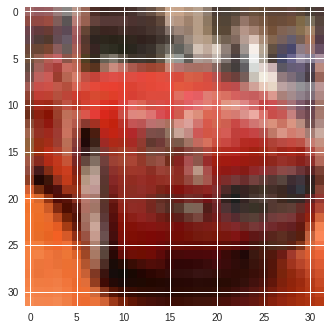

In [5]:
# 画像データ(画像)の確認
import matplotlib.pyplot as plt
plt.imshow(x_train[5])  # 画像表示
print(y_train[5])  # ついでにラベル番号も表示

In [0]:
# 画像データ(配列)の確認
# （データは32×32で、それぞれにRGB値(0-255)が格納されている）
print(x_train[5])

In [0]:
# ＜参考＞　使っている画像のサムネイルを作って表示
dlt.utils.plot_examples(data,num_examples=3,fname='examples.jpg')   # 取りあえず3行ほど作成
from IPython.display import Image,display_jpeg
display_jpeg(Image('./examples.jpg'))

In [0]:
# 学習の前処理として特徴量のスケールを揃えるためにRGBを正規化する（0～255のRGB値を255で割り算して、0～1の値に正規化する）
x_train = x_train.astype('float32') / 255    # 学習用の画像データ
x_test = x_test.astype('float32') / 255    #テスト用の画像データ
#print(x_train[5])      # 一応、確認

機械学習に適用させるため、ラベルデータをone-hotベクトルに変換（しないとダメらしい） \\
例)ラベルは番号で格納されている(carは1、frogは6とか。これをone-hot表現(以下のようなもの)に変換する \\
>"1"　→　[0,1,0,0,0,0,0,0,0,0] \\
>”6”　→　[0,0,0,0,0,0,1,0,0,0]　　※0,1,2,3,4,5,6の順なので7個めに1がたつ


In [0]:
from keras.utils.np_utils import to_categorical  # Kerasのto_categorical()を使って変換
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)
print(y_train[0])

### 学習モデルの構築

**モデルを構築**

In [0]:
from keras.models import Sequential    # ライブラリのインポート
from keras.layers import Dense, Dropout, Activation, Conv2D, MaxPooling2D, Flatten
from keras.optimizers import Adam

model = Sequential()    # インスタンス作成（Sequentialモデル。シンプルで一般的なモデルとか・・？）

# CNNの1層目レイヤー
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu' , padding='same', input_shape=(32,32,3)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2層目
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu' , padding='same'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 出力層
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Activation('softmax'))

**モデルを学習**

※エポック10で30分ちょいかかる。。。ちなみにGPUだと2分かからなかった。

In [0]:
model.compile(loss='categorical_crossentropy', 
              optimizer=Adam(lr=0.001), 
              metrics=['accuracy'])
fit = model.fit(x_train, y_train,    # 訓練用入力データ
              batch_size=128,        # バッチサイズ(同時計算するサンプル数)
              epochs=30,             # エポック(学習のサイクル数) 10->2
              verbose=1,             # 結果の出力
              validation_split=0.1   # ホールドアウト検証として使うデータの割合
                )

In [0]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))     # モデルの可視化

In [0]:
model.save('MyNet_cifar10.h5')

**モデルを評価**

In [0]:
score = model.evaluate(x_test, y_test,verbose=0)     # 損失値の計算
print('Test score:', score[0])       # 損失値(1-損失値)
print('Test accuracy:', score[1])    # 正確さ

In [0]:
fit.history.keys()  # 学習履歴の項目確認

In [0]:
# 学習経過をプロット
import matplotlib.pyplot as plt 

plt.plot(range(1, 31), fit.history['acc'], label="training")         # epocに応じて変更range 11->3 
plt.plot(range(1, 31), fit.history['val_acc'], label="validation")   # epocに応じて変更range 11->3
plt.xlabel('Epochs') 
plt.ylabel('Accuracy') 
plt.legend() 
plt.show()

### 推論のテスト

予めGoogleドライブに保存してある画像で推論実施（事前マウント必要）。

In [0]:
#---認識テスト画像の確認表示----
import numpy as np
from PIL import Image
img_width = 256 ; img_height = 256
#file_path = './kuru1.jpg'  # 読み込むファイルを指定(local)
file_path = 'gdrive/My Drive/otr_dog2.jpg'  # 読み込むファイルを指定(google drive)
img = Image.open(file_path).convert('RGB') # Gray->L, RGB->RGB
img = img.resize((img_width, img_height))
x = np.array(img, dtype=np.float32)
x = x / 255
plt.imshow(x)
plt.show()

#---テスト画像の変換----
from keras.preprocessing.image import img_to_array, load_img
img = img_to_array(load_img(file_path, target_size=(32,32)))  # 読み込み
img_nad = img_to_array(img)/255   # 0-1に変換
img_nad = img_nad[None, ...]  # Kerasで使用する場合、最初にサンプル数のついた4次元配列に変換する(例： 1,224,224,3)

#---読み込んだテスト画像で推論-----
model.load_weights('MyNet_cifar10.h5')
pred = model.predict(img_nad, batch_size=1, verbose=0)
pred_score = np.max(pred)
pred_label = np.argmax(pred)
print('--------------------------------------')
print('予測スコア:', pred_score * 100 , '%')       # 
print('予測ラベル:', pred_label)    # 
print('**ラベル名取得が不明なので、とりあえず凡例表示(-_-;)**')
print('0:airplane(飛行機)  ,  1:automobile(自動車)  ,  2:bird(鳥)  ,  3:cat(猫)  ,  4:deer(鹿)  ,  ')
print('5:dog(犬)  ,  6:frog(カエル)  ,  7:horse(馬)  ,  8:ship(船)  ,  9:truck(トラック)')

In [0]:
#---認識テスト画像の確認表示----
import numpy as np
from PIL import Image
img_width = 256 ; img_height = 256
#file_path = './kuru1.jpg'  # 読み込むファイルを指定(local)
file_path = 'gdrive/My Drive/fune1.jpg'  # 読み込むファイルを指定(google drive)
img = Image.open(file_path).convert('RGB') # Gray->L, RGB->RGB
img = img.resize((img_width, img_height))
x = np.array(img, dtype=np.float32)
x = x / 255
plt.imshow(x)
plt.show()

#---テスト画像の変換----
from keras.preprocessing.image import img_to_array, load_img
img = img_to_array(load_img(file_path, target_size=(32,32)))  # 読み込み
img_nad = img_to_array(img)/255   # 0-1に変換
img_nad = img_nad[None, ...]  #4次元配列に変換

#---読み込んだテスト画像で推論-----
model.load_weights('MyNet_cifar10.h5')
pred = model.predict(img_nad, batch_size=1, verbose=0)
pred_score = np.max(pred)
pred_label = np.argmax(pred)
print('--------------------------------------')
print('予測スコア:', pred_score * 100 , '%')       # 
print('予測ラベル:', pred_label)    # 
print('**ラベル名取得が不明なので、とりあえず凡例表示(-_-;)**')
print('0:airplane(飛行機)  ,  1:automobile(自動車)  ,  2:bird(鳥)  ,  3:cat(猫)  ,  4:deer(鹿)  ,  ')
print('5:dog(犬)  ,  6:frog(カエル)  ,  7:horse(馬)  ,  8:ship(船)  ,  9:truck(トラック)')

In [0]:
#---認識テスト画像の確認表示----
import numpy as np
from PIL import Image
img_width = 256 ; img_height = 256
#file_path = './kuru1.jpg'  # 読み込むファイルを指定(local)
file_path = 'gdrive/My Drive/hikouki1.jpg'  # 読み込むファイルを指定(google drive)
img = Image.open(file_path).convert('RGB') # Gray->L, RGB->RGB
img = img.resize((img_width, img_height))
x = np.array(img, dtype=np.float32)
x = x / 255
plt.imshow(x)
plt.show()

#---テスト画像の変換----
from keras.preprocessing.image import img_to_array, load_img
img = img_to_array(load_img(file_path, target_size=(32,32)))  # 読み込み
img_nad = img_to_array(img)/255   # 0-1に変換
img_nad = img_nad[None, ...]  #4次元配列に変換

#---読み込んだテスト画像で推論-----
model.load_weights('MyNet_cifar10.h5')
pred = model.predict(img_nad, batch_size=1, verbose=0)
pred_score = np.max(pred)
pred_label = np.argmax(pred)
print('--------------------------------------')
print('予測スコア:', pred_score * 100 , '%')       # 
print('予測ラベル:', pred_label)    # 
print('**ラベル名取得が不明なので、とりあえず凡例表示(-_-;)**')
print('0:airplane(飛行機)  ,  1:automobile(自動車)  ,  2:bird(鳥)  ,  3:cat(猫)  ,  4:deer(鹿)  ,  ')
print('5:dog(犬)  ,  6:frog(カエル)  ,  7:horse(馬)  ,  8:ship(船)  ,  9:truck(トラック)')

### （その他）メモ書きなど

めも \\
[自前画像で学習させるときの参考URL(Qiita)](https://qiita.com/neet-AI/items/2b3d7f743e4d6c6d8e10)

**(Google DriveからColabへのファイルアップロード)**

In [0]:
!!pip install -U -q PyDrive

In [0]:
# Google Driveアクセス準備
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# Google Driveからのコピー
id = '1647A__arJOx8rzagARRxknA4RVVJFO3J'  # 共有リンクで取得した id= より後の部分
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('mocha.zip')
# 終わったら、ファイル画面の更新をして確認

In [0]:
# Zipの場合は展開
!unzip mocha.zip

---

In [0]:
# 任意画像の分類確認用　　うまく動かない・・・
from google.colab import files
uploaded = files.upload()

import cv2
import matplotlib.pyplot as plt
import os.path

file = uploaded.values
#file ='sample9.jpg'
if os.path.exists(file):
  img = cv2.imread(file)
  show_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
  plt.imshow(show_img)
  plt.show()

In [0]:
!whoami

root
